# Temperature variance budgets
In the appendix of the manuscript, we present the steady-state budget equation for the wall-normal profile of temperature variance $\overline{T'^2}$. We can extract this data from the time-averaged profiles processed by `collect_profiles.ipynb`

In [1]:
# Begin by loading the required pacakages
import afidtools as afid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Use seaborn to make nice plots, and set a specific colour palette
plt.rc("figure", dpi=200)
sns.set_context("paper")
sns.set_style("ticks")

UTcols = [
    "#EBBDA9", "#CF0072", "#4F2D7F", "#002C5F", "#0094B3", "#63B1E5", "#00675A", "#3F9C35",
    "#887B1B", "#FED100", "#EC7A08", "#C60C30", "#822433", "#513C40", "#616365", "#ADAFAF"
]
sns.set_palette(UTcols[1::2])
sns.color_palette(UTcols[1::2])

[(0.8117647058823529, 0.0, 0.4470588235294118),
 (0.0, 0.17254901960784313, 0.37254901960784315),
 (0.38823529411764707, 0.6941176470588235, 0.8980392156862745),
 (0.24705882352941178, 0.611764705882353, 0.20784313725490197),
 (0.996078431372549, 0.8196078431372549, 0.0),
 (0.7764705882352941, 0.047058823529411764, 0.18823529411764706),
 (0.3176470588235294, 0.23529411764705882, 0.25098039215686274),
 (0.6784313725490196, 0.6862745098039216, 0.6862745098039216)]

## Define functions to compute derivatives
To calculate the budget terms, we need to calculate the first derivative of the mean temperature and the second derivative of the variance.
Since the mean temperature $\overline{T}(x)$ is anti-symmetric, we impose 0 as a boundary condition at the cell centre in `ddx`, and since the variance is symmetric, we can impose zero gradient at the cell centre in `d2x`

In [3]:
def d2x(A, x, BClo=0.0):
    dx = x[1:] - x[:-1]
    dp = dx[1:]
    dm = dx[:-1]
    
    # Compute second derivative in interior
    d2A = np.zeros(A.shape)
    d2A[1:-1] = 2.0/(dp + dm)*(
        A[2:]/dp + A[:-2]/dm - A[1:-1]*(1/dp+1/dm)
    )
    
    # Lower boundary (x=0 wall)
    dp = dx[0]
    dm = x[0]
    d2A[0] = 2.0/(dp + dm)*(
        A[1]/dp + BClo/dm - A[0]*(1/dp+1/dm)
    )
    
    # Upper boundary (x=0.5 channel centre)
    dp = 1.0 - x[-1]
    dm = dx[-1]
    
    # Set upper BC equal to the last entry
    # to enforce a zero gradient boundary condition
    # at the channel centre
    BCup = A[-1]
    d2A[-1] = 2.0/(dp + dm)*(
        BCup/dp + A[-2]/dm - A[-1]*(1/dp+1/dm)
    )
    return d2A

In [4]:
def ddx(A, x, BClo=0.0):
    dA = np.zeros(A.size)
    vA = np.array(A)
    xv = np.array(x)
    dA[1:-1] = (vA[2:] - vA[:-2])/(xv[2:] - xv[:-2])
    dA[0] = (vA[1] - BClo)/xv[1]
    # Assume an antisymmetric profile, and use 0 as BC
    # at the channel centre
    dA[-1] = (0.0 - vA[-2])/(0.5 - xv[-2])
    return dA

## Load in the data for all simulations

In [5]:
# Load the time-averaged data generated by `collect_profiles.ipynb`
df = pd.read_csv("base_profiles.csv", index_col=0)
dfr = pd.read_csv("ref_profiles.csv", index_col=0)

## Specify which simulations to take data from
Recall that when $Le<1$, we use the simulation variable `S` to denote temperature since it is diffusing more slowly and needs higher resolution. This is why we set `Sc`=100 and `Pr`=10 for the $Le=0.1$ case

In [6]:
Le = np.array([0.1, 1, 10, 100])
Sc = np.array([100, 100, 100, 100])
Pr = np.array([10, 10, 10, 1])
Rρ = np.array([50, 0.02, 0.02, 0.02])

## Calculate and collect budget terms
Note that we do not have sufficient data saved to directly compute the transport term, and simply take it as minus the sum of the other terms since the budget should be closed. This is a reasonable assumption given the statistical stationarity exhibited in other quantities

In [7]:
x, D, T, P, Chi = [], [], [], [], []

for i in range(len(Le)):
    # For the first two cases, use data from the salinity field
    if Le[i]<=1:
        # Select the data subset
        sdf = dfr[(dfr.Rρ==Rρ[i]) & (dfr.Pr==Pr[i]) & (dfr.Sc==Sc[i])]
        
        # Read in the grid, turbulent flux, and variance
        xm = np.array(sdf['x'])
        uT = sdf['vxS']
        Tp2 = np.array(sdf['Sp2'])
        # In the Le=0.1 case, we have switched T and S, so the
        # BC at the wall is different
        if Rρ[i] > 1:
            BClo = 0.5
        else:
            BClo = -0.5
        # Compute the mean gradient
        dT = ddx(sdf['Sbar'], xm, BClo=BClo)
        # Only include perturbation contributions in chi
        chiT = sdf['chiS'] - sdf['κS']*dT**2
        # Record the dimensionless diffusivity
        κ = sdf['κS']
    
    # Do the same for Le>1, using the temperature data
    else:
        sdf = df[(df.Rρ==Rρ[i]) & (df.Pr==Pr[i]) & (df.Sc==Sc[i])]
        xm = np.array(sdf['x'])
        uT = sdf['vxT']
        Tp2 = np.array(sdf['Tp2'])
        dT = ddx(sdf['Tbar'], xm, BClo=-0.5)
        chiT = sdf['chiT'] - sdf['κT']*dT**2
        κ = sdf['κT']
        
    # Compute budget terms (diffusion, production, transport)
    diff = κ*d2x(Tp2, xm)
    prod = -uT*dT
    trsp = -diff + chiT - prod
    
    # Store variables in list
    x.append(xm)
    D.append(diff)
    T.append(trsp)
    P.append(prod)
    Chi.append(chiT)

Here, we just define a function to add a label to the corner of the plot panel

In [8]:
def anno_tr(ax, str):
    l, r = ax.get_xlim()
    b, t = ax.get_ylim()
    ax.annotate(
        str, (r, t), xytext=(-3, -3),
        textcoords="offset points",
        ha="right", va="top"
    )
    return

## Construct the figure!

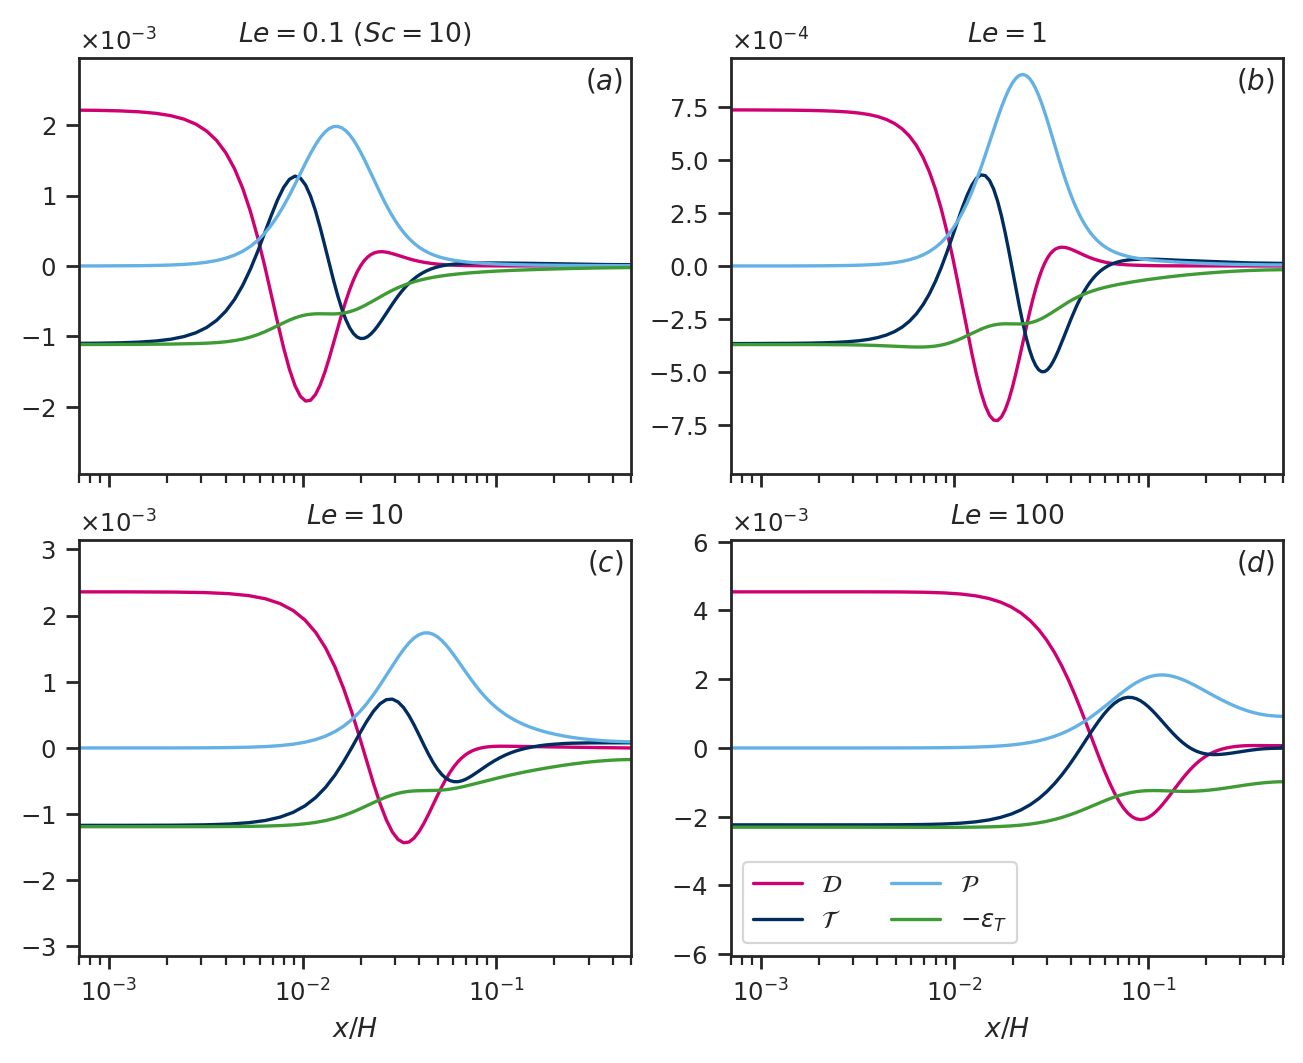

In [9]:
# Prescribe axes titles and panel labels
titles = [
    "$Le=0.1 \ (Sc=10)$", "$Le=1$", "$Le=10$", "$Le=100$"
]
labels = ["$(a)$", "$(b)$", "$(c)$", "$(d)$"]

# Make figure with 4 panels
fig, ax = plt.subplots(2,2, figsize=(6.4,5.2), dpi=200, constrained_layout=True, sharex=True)

# Loop over the collected data
for i in range(len(x)):
    # Select the subplot
    axx = ax[i//2,i%2]
    
    # Plot the budget terms
    axx.plot(x[i], D[i], label="$\mathcal{D}$")
    axx.plot(x[i], T[i], label="$\mathcal{T}$")
    axx.plot(x[i], P[i], label="$\mathcal{P}$")
    axx.plot(x[i], -Chi[i], label="$-\\varepsilon_T$")
    
    # Scale the x-axis on a log scale
    axx.semilogx()
    
    # Set axis limits and label formats
    axx.set_xlim([7e-4,0.5])
    ymax = np.max(D[i])
    axx.set_ylim([-1.33*ymax, 1.33*ymax])
    axx.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
    
    # Add legend to last subplot
    if i==3:
        axx.legend(ncol=2)
    # Add axis labels and titles
    if i//2==1:
        axx.set_xlabel("$x/H$")
    axx.set_title(titles[i])
    anno_tr(axx, labels[i])
    
# Save figure to file
fig.savefig("var_budget.pdf")